<a href="https://colab.research.google.com/github/crisouzajr/Deep-Learning-Projects/blob/Airline-Passagers-Prediction-(LSTM)/AIRLINE(LSTM)_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de Série Temporal

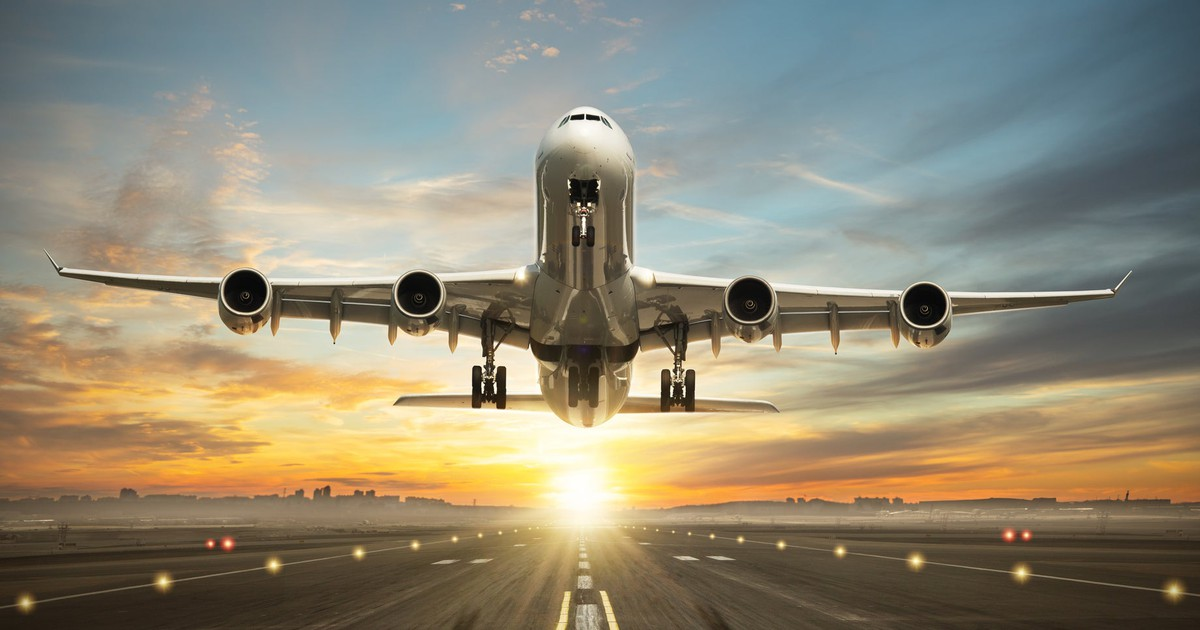

A base de dados faz referência ao aumento do volume de passageiros em um intervalo de tempo.

* O objetivo desse notebook é demonstrar como alterações buscando otimizações, podem ser feitas na estrutura da Rede Neural, onde resultados melhores podem ser alcançadas, bem como utilizar de diferentes arquiteturas e comparar as variáveis de métricas e determinar qual RN se encaixa melhor de acordo com a base de dados apresentada.

As mudanças serão as seguintes:


* Épocas=1000, batch_size=28, Window=9, Lookback=3
* Separar conjunto de validação 10%
* Adicionar o ModelCheckpoint
* Adicionar Early Stopping
* Avaliar melhor modelo salvo em best.h5

Essas foram as melhores características encontradas para o modelo preditivo desta Série Temporal.




In [ ]:
# Processamento dos Dados
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Normalização
from sklearn.preprocessing import MinMaxScaler

# Rede Neural
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
import tensorflow as tf
from keras.utils.vis_utils import plot_model

# Treinamento
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Métricas
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Parte 1 - Preprocessamento de Dados

### Semente Inicial

In [ ]:
seed=10
import random
np.random.seed(seed) 
random.seed(seed)
import tensorflow
tensorflow.random.set_seed(seed)

### Importar a base de dados

In [ ]:
dataset_train = pd.read_csv('train.csv')
#dataset_train.head()

In [ ]:
training_set = dataset_train.iloc[:, 1:2].values #só coluna da série em si
#training_set[0:5]

### Gráfico da Série Temporal

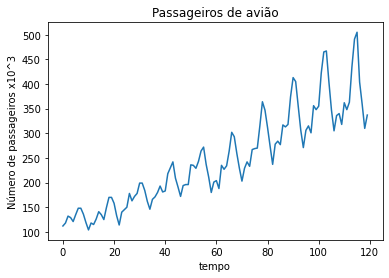

In [ ]:
plt.plot(training_set)
plt.xlabel("tempo")
plt.ylabel("Número de passageiros x10^3")
plt.title("Passageiros de avião")
plt.show()

### Normalização

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
#training_set_scaled[0:5]

### Criar a estrutura de dados com janela 3 + o mesmo mês no ano passado e output 1

In [ ]:
window = 9
look_back = 3
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    # X_train.append(training_set_scaled[i-window:i, 0])
    X_train.append(np.hstack((training_set_scaled[i-window,0], training_set_scaled[i-look_back:i,0])))
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
pd.DataFrame(X_train).head(2)

,0,1,2,3
0,0.019950,0.109726,0.109726,0.079800
1,0.034913,0.109726,0.079800,0.037406


In [ ]:
pd.DataFrame(y_train).head(2)

,0
0,0.037406
1,0.000000


### Reshaping

In [ ]:
X_train.shape

(111, 4)

Shape de input da LSTM = (batch_size, timesteps, features)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
X_train.shape

(111, 4, 1)

## Parte 2 - Construção da RNN

In [ ]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída (1)
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer =  'adam', loss = 'mean_squared_error') #sdg

# Visualizar a rede
regressor.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 4, 100)            40800     
                                                                 
 dropout_44 (Dropout)        (None, 4, 100)            0         
                                                                 
 lstm_50 (LSTM)              (None, 4, 80)             57920     
                                                                 
 dropout_45 (Dropout)        (None, 4, 80)             0         
                                                                 
 lstm_51 (LSTM)              (None, 50)                26200     
                                                                 
 dropout_46 (Dropout)        (None, 50)                0         
                                                                 
 dense_13 (Dense)            (None, 1)               

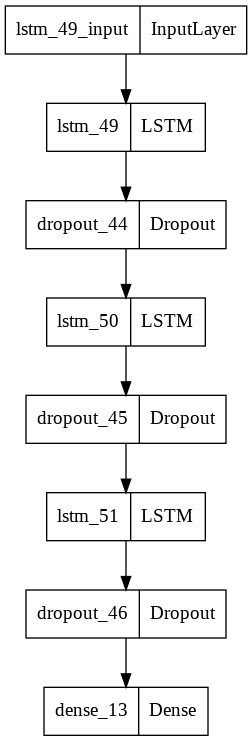

In [ ]:
plot_model(regressor)

### Treinamento

In [ ]:
es = EarlyStopping(patience=100)
rlr = ReduceLROnPlateau(patience=100)
mc = ModelCheckpoint(filepath='best.h5', save_best_only=True) # se quiser manter um tracking da época e do erro: 'best_{epoch:03d}-{val_loss:.4f}.h5'

history = regressor.fit(X_train, y_train, epochs = 1000, batch_size = 28, validation_split=0.1, callbacks=[es, mc, rlr])

Epoch 1/1000
4/4 [==============================] - 8s 466ms/step - loss: 0.1463 - val_loss: 0.4015 - lr: 0.0010
Epoch 2/1000
4/4 [==============================] - 0s 32ms/step - loss: 0.1061 - val_loss: 0.2747 - lr: 0.0010
Epoch 3/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.0546 - val_loss: 0.1177 - lr: 0.0010
Epoch 4/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.0259 - val_loss: 0.0274 - lr: 0.0010
Epoch 5/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.0353 - val_loss: 0.0279 - lr: 0.0010
Epoch 6/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.0267 - val_loss: 0.0558 - lr: 0.0010
Epoch 7/1000
4/4 [==============================] - 0s 26ms/step - loss: 0.0252 - val_loss: 0.0810 - lr: 0.0010
Epoch 8/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.0226 - val_loss: 0.0649 - lr: 0.0010
Epoch 9/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.0168 - val_loss: 0.0376 - lr

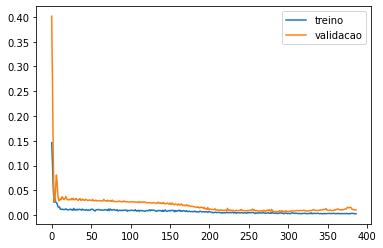

In [ ]:
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validacao')
plt.legend();

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [ ]:
dataset_test = pd.read_csv('test.csv')
test_airline = dataset_test.iloc[:, 1:2].values

### Construir a estrutura para teste

In [ ]:
dataset_total = pd.concat((dataset_train.iloc[:,1], dataset_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    # X_test.append(inputs[i-window:i, 0])
    X_test.append(np.hstack((inputs[i-window,0], inputs[i-look_back:i,0])))
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [ ]:
predicted_airline = regressor.predict(X_test)
#predicted_airline[0:5]

In [ ]:
predicted_airline = sc.inverse_transform(predicted_airline)
#predicted_airline[0:5]

### Visualizar os resultados de treino e teste

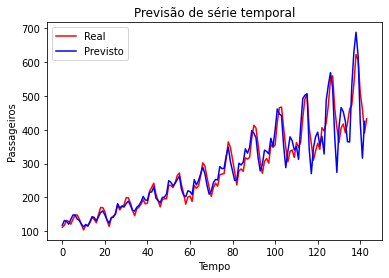

In [ ]:
allTargetData = np.vstack((training_set, test_airline))

training_predicted_airline = regressor.predict(X_train)
training_predicted_airline = sc.inverse_transform(training_predicted_airline)

allForecastedData = np.vstack((training_set[1:window], training_predicted_airline, predicted_airline))

# Visualizar os resultados de Treino e Teste
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Passageiros')
plt.legend()
plt.savefig('predictions_training_test.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [ ]:
rmse = math.sqrt(mean_squared_error(test_airline, predicted_airline))
print('RMSE: ', rmse)

RMSE:  57.83415091988897


In [ ]:
mse = mean_squared_error(test_airline, predicted_airline)
print('MSE: ',mse)

MSE:  3344.7890126244943


In [ ]:
mape = np.mean(np.abs((test_airline - predicted_airline) / test_airline)) * 100
print('MAPE: ',mape, '%')

MAPE:  10.45322281707101 %


In [ ]:
print('R2: ', r2_score(test_airline, predicted_airline))

R2:  0.400219393210666


# Vamos agora refazer os testes para o melhor modelo salvo: ModelCheckPoint

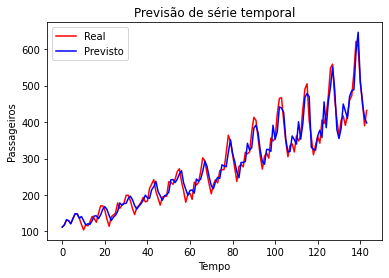

In [ ]:
regressor.load_weights('best.h5') # carrega os pesos da melhor rede
predicted_airline = regressor.predict(X_test)
predicted_airline = sc.inverse_transform(predicted_airline)

allTargetData = np.vstack((training_set, test_airline))
training_predicted_airline = regressor.predict(X_train)
training_predicted_airline = sc.inverse_transform(training_predicted_airline)
allForecastedData = np.vstack((training_set[0:window], training_predicted_airline, predicted_airline))


plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Passageiros')
plt.legend()
plt.savefig('predictions_training_test.svg')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(test_airline, predicted_airline))
print('RMSE: ', rmse)

mse = mean_squared_error(test_airline, predicted_airline)
print('MSE: ',mse)

mape = np.mean(np.abs((test_airline - predicted_airline) / test_airline)) * 100
print('MAPE: ',mape, '%')

print('R2: ', r2_score(test_airline, predicted_airline))

RMSE:  30.841061570245227
MSE:  951.171078779657
MAPE:  5.942568643766723 %
R2:  0.8294379810990562
